In [1]:
import json
from pathlib import Path
import random
import pprint

import matplotlib
import matplotlib.pyplot as plt

import os

import torch

from config import load_config
from data import build_datasets, CollatorForMaskedSelectedTokens, CollatorForMaskedRandomSelectedTokens, IdentityCollator
from data import ALL_POSSIBLE_COLORS
from model import MultimodalModel, MultimodalPretrainingModel
from lightning import Trainer, seed_everything
from tqdm.auto import tqdm, trange

from PIL import Image

from torch.utils.data import DataLoader, Subset
from torch.nn.functional import softmax


pp = pprint.PrettyPrinter(indent=2)

2024-06-15 14:35:44.648980: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-8.0/lib64/
2024-06-15 14:35:44.649043: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def scene_tensor_to_txt(tensor):
    return ' '.join([processor.inv_vocabulary[t] for t in tensor.tolist()])

def print_scene_tensor(tensor):
    scene_text = scene_tensor_to_txt(tensor)
    print(scene_text.replace('[PAD]', '').replace('[SEP]','\n     '))
    
def print_parallel(tensor0, tensor1, tensor2, confidences, titles):
    ttl0, ttl1, ttl2 = titles
    print(f'{ttl0:6.6s} {ttl1:6.6s} {ttl2:6.6s}')
    for t0, t1, t2, conf in zip(
            tensor0.tolist(), tensor1.tolist(), tensor2.tolist(), confidences.tolist()):
        w0 = processor.inv_vocabulary[t0]
        w1 = processor.inv_vocabulary[t1]
        w2 = processor.inv_vocabulary[t2]
        
        if w0 == '[SEP]':
            print()
            continue
        if w0 == '[PAD]':
            break
        
        print_txt = f'{w0:6.6s} {w1:6.6s} {w2:6.6s} ({conf:.4f})'
        if w0 != w2:
            print_txt = bold(print_txt)
            

        print(print_txt)
        
def bold(text):
    return ("\033[1m" + text + "\033[0m")

In [3]:
exp_name = 'multimodal-pretraining-v3--mlm_probability=0.15' 
# exp_name = 'multimodal-pretraining-v3--n_colors=139--mlm_probability=0.15'
# exp_name = 'multimodal-pretraining-v3--n_colors=139b--mlm_probability=0.15'
# exp_name = 'multimodal-pretraining-v3--n_colors=216b--mlm_probability=0.15'
# exp_name = 'multimodal-pretraining-v3--n_colors=139b_to_8_by_random--mlm_probability=0.15'
# exp_name = 'multimodal-pretraining-v3--n_colors=216b_to_8_by_random--mlm_probability=0.15'

title_exp_name = {
    'multimodal-pretraining-v3--mlm_probability=0.15' : '8 Colors (Base)',
    'multimodal-pretraining-v3--n_colors=139--mlm_probability=0.15' : '139 Colors Dataset A',
    'multimodal-pretraining-v3--n_colors=139b--mlm_probability=0.15' : '139 Colors Dataset B',
    'multimodal-pretraining-v3--n_colors=216b--mlm_probability=0.15' : '216 Colors Dataset B',
    'multimodal-pretraining-v3--vit--mlm_probability=0.15' : '8 Colors Vit Encoder',
    'multimodal-pretraining-v3--n_colors=139b_to_8_by_random--mlm_probability=0.15': '139 Colors with Label Pooling',
    'multimodal-pretraining-v3--n_colors=216b_to_8_by_random--mlm_probability=0.15': '216 Colors with Label Pooling',
}[exp_name]

resume_from_path = f'outputs/{exp_name}/last.ckpt'
# resume_from_path = f'outputs/{exp_name}/last-v1.ckpt'

checkpoint = torch.load(resume_from_path)

print('Epoch:', checkpoint['epoch'])

Epoch: 999


In [4]:
!ls outputs/$exp_name

'epoch=109-step=15070.ckpt'  'epoch=579-step=79460.ckpt'
'epoch=119-step=16440.ckpt'  'epoch=589-step=80830.ckpt'
'epoch=129-step=17810.ckpt'  'epoch=599-step=82200.ckpt'
'epoch=139-step=19180.ckpt'  'epoch=59-step=8220.ckpt'
'epoch=149-step=20550.ckpt'  'epoch=609-step=83570.ckpt'
'epoch=159-step=21920.ckpt'  'epoch=619-step=84940.ckpt'
'epoch=169-step=23290.ckpt'  'epoch=629-step=86310.ckpt'
'epoch=179-step=24660.ckpt'  'epoch=639-step=87680.ckpt'
'epoch=189-step=26030.ckpt'  'epoch=649-step=89050.ckpt'
'epoch=199-step=27400.ckpt'  'epoch=659-step=90420.ckpt'
'epoch=19-step=2740.ckpt'    'epoch=669-step=91790.ckpt'
'epoch=209-step=28770.ckpt'  'epoch=679-step=93160.ckpt'
'epoch=219-step=30140.ckpt'  'epoch=689-step=94530.ckpt'
'epoch=229-step=31510.ckpt'  'epoch=699-step=95900.ckpt'
'epoch=239-step=32880.ckpt'  'epoch=69-step=9590.ckpt'
'epoch=249-step=34250.ckpt'  'epoch=709-step=97270.ckpt'
'epoch=259-step=35620.ckpt'  'epoch=719-step=98640.ckpt'
'epoch=269-step=36990.ckpt'  'epoch

In [5]:
config = load_config(exp_name)

config.vocabulary_path = config.vocabulary_path.replace('/workspace/' ,'/workspace1/')
config.base_path = config.base_path.replace('/workspace/' ,'/workspace1/')

Loading multimodal-pretraining-v3--mlm_probability=0.15 last checkpoint config from outputs/multimodal-pretraining-v3--mlm_probability=0.15/last.ckpt
Add new arg: use_embedding_loaded = 
Add new arg: adapt_embedding_from = 0
Add new arg: use_vit_embedding_loaded = False
Add new arg: token_translation_path = 
Add new arg: use_curriculum = False


In [6]:
pp.pprint(vars(config))

{ 'adapt_embedding_from': 0,
  'aug_zero': 0,
  'aug_zero_independent': False,
  'base_path': '/workspace1/fidelrio/CLEVR_CoGenT_v1.0',
  'batch_size': 256,
  'comet_experiment_key': '88cbee2f282648bfa37fa8f27872f8af',
  'd_hidden': 256,
  'display_object_properties': False,
  'filter_symmetric_relations': True,
  'freeze_vit_embedding': False,
  'image_pretraining': False,
  'lr': 0.0001,
  'max_epochs': 1000,
  'max_question_size': 45,
  'max_scene_size': 60,
  'mlm_probability': 0.15,
  'mp_probability': 0.75,
  'multimodal_pretraining': True,
  'multimodal_training': False,
  'n_head': 4,
  'n_layers': 4,
  'n_outputs': 28,
  'n_patches': 196,
  'n_tokens': 96,
  'not_normalize_image': False,
  'only_front_right_relations': False,
  'optimizer': 'adam',
  'pad_idx': 1,
  'patch_height': 16,
  'patch_width': 16,
  'profile': False,
  'rels_to_sample': 0,
  'resume_training': False,
  'seed': 42,
  'shuffle_object_identities': True,
  'start_from': '',
  'token_translation_path': '',

In [7]:
train_dataset, test_dataset, systematic_dataset = build_datasets(config)
config.pad_idx = train_dataset.pad_idx

In [8]:
model = MultimodalModel(config)
training_model = MultimodalPretrainingModel(model, config)
training_model.load_state_dict(checkpoint['state_dict'])

/home/fidelrio/.pyenv/versions/systematicity/lib/python3.7/site-packages/lightning/pytorch/utilities/parsing.py:270: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."


<All keys matched successfully>

In [15]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

5575008

In [9]:
processor = test_dataset.processor

In [10]:
relation_tokens = sorted([processor.vocabulary[w] for w in ['left', 'right', 'behind', 'front']])
color_tokens = sorted(
    [processor.vocabulary[w] for w in ALL_POSSIBLE_COLORS if w in processor.vocabulary])
shapes_tokens = sorted([processor.vocabulary[w] for w in ['cylinder', 'sphere', 'cube']])
materials_tokens = sorted([processor.vocabulary[w] for w in ['metal', 'rubber']])
size_tokens = sorted([processor.vocabulary[w] for w in ['small', 'large']])

In [11]:
# collator = CollatorForMaskedLanguageModeling(config, processor)
collator = CollatorForMaskedSelectedTokens(config, processor, tokens=color_tokens)
# collator = CollatorForMaskedRandomSelectedTokens(config, processor, tokens=shapes_tokens, p=0.2)
# collator = IdentityCollator(config, processor)

In [12]:
# sample_idx = 333
sample_idx = random.randint(0, len(test_dataset))
image, scene = test_dataset.retrieve_raw(sample_idx)
image_tensor, scene_tensor = test_dataset[sample_idx]

collated_images, collated_scenes, collated_labels = collator([(image_tensor, scene_tensor)])

print(sample_idx)

9747


[CLS] [O2] small yellow rubber cube 
      [O6] large red rubber cylinder 
      [O9] small green metal sphere 
      [O5] large gray rubber sphere 
      [O4] large red metal sphere 
      [O1] large yellow metal cube 
      [O3] small cyan metal sphere 
      [O7] large blue rubber cube 
      [O0] large yellow metal cube 
      [O8] small yellow rubber cube

[CLS] [O2] small [MASK] rubber cube 
      [O6] large [MASK] rubber cylinder 
      [O9] small [MASK] metal sphere 
      [O5] large [MASK] rubber sphere 
      [O4] large [MASK] metal sphere 
      [O1] large [MASK] metal cube 
      [O3] small [MASK] metal sphere 
      [O7] large [MASK] rubber cube 
      [O0] large [MASK] metal cube 
      [O8] small [MASK] rubber cube


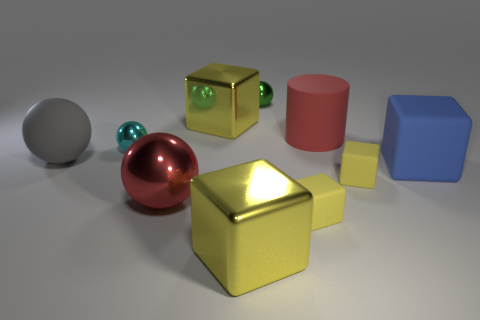

In [13]:
print_scene_tensor(scene_tensor)
print()
print_scene_tensor(collated_scenes[0])

image

In [14]:
output_logits = model(collated_images, collated_scenes)

confidences = softmax(output_logits, dim=-1).max(dim=-1).values
predictions = output_logits.argmax(dim=-1)

In [ ]:
print_parallel(
    scene_tensor,
    collated_scenes[0],
    predictions[0][-config.max_scene_size:],
    confidences[0][-config.max_scene_size:],
    titles=['gd_tth', 'input', 'output']
)

In [ ]:
trainer = Trainer(max_epochs=config.max_epochs,
                  accelerator="gpu",
                  devices=torch.cuda.device_count()
)

In [ ]:
vocab = processor.vocabulary

relation_tokens = sorted(
    [vocab[w] for w in ['left', 'right', 'behind', 'front'] if w in vocab])
color_tokens = sorted(
    [vocab[w] for w in ALL_POSSIBLE_COLORS if w in vocab])
#     [vocab[w] for w in ['blue', 'brown', 'cyan', 'green', 'red', 'purple', 'yellow', 'gray']])
shapes_tokens = sorted(
    [vocab[w] for w in ['cylinder', 'sphere', 'cube'] if w in vocab])
materials_tokens = sorted(
    [vocab[w] for w in ['metal', 'rubber'] if w in vocab])
size_tokens = sorted(
    [vocab[w] for w in ['small', 'large'] if w in vocab])

random_baseline = {
    'relation':  1 / len(relation_tokens),
    'color':  1 / len(color_tokens),
    'shapes':  1 / len(shapes_tokens),
    'materials':  1 / len(materials_tokens),
    'size':  1 / len(size_tokens),
    'identity':  1 / len(processor.vocabulary),
}

In [ ]:
random_baseline

In [ ]:
from torch.utils.data import Subset
import random

In [ ]:
test_dataset_original = test_dataset
systematic_dataset_original = systematic_dataset

In [ ]:
# train_indices = random.sample(range(len(train_dataset)), k=5000)
# train_dataset_subset = Subset(train_dataset, train_indices)
# test_indices = random.sample(range(len(test_dataset)), k=5000)
# test_dataset_subset = Subset(test_dataset, test_indices)
# systematic_indices = random.sample(range(len(systematic_dataset)), k=5000)
# systematic_dataset_subset = Subset(systematic_dataset, systematic_indices)

train_dataset_subset = train_dataset
test_dataset_subset = test_dataset
systematic_dataset_subset = systematic_dataset

In [ ]:
%%time

collate_fns = {
    'selected': [
        ('color', CollatorForMaskedSelectedTokens(config, processor, tokens=color_tokens)),
        ('shapes', CollatorForMaskedSelectedTokens(config, processor, tokens=shapes_tokens)),
        ('materials', CollatorForMaskedSelectedTokens(config, processor, tokens=materials_tokens)),
        ('size', CollatorForMaskedSelectedTokens(config, processor, tokens=size_tokens)),
    #     ('relation', CollatorForMaskedSelectedTokens(config, processor, tokens=relation_tokens)),
    #     ('identity', IdentityCollator(config, processor)),
    ],
    'random': [
        ('color', CollatorForMaskedRandomSelectedTokens(config, processor, tokens=color_tokens, p=0.2)),
        ('shapes', CollatorForMaskedRandomSelectedTokens(config, processor, tokens=shapes_tokens, p=0.2)),
        ('materials', CollatorForMaskedRandomSelectedTokens(config, processor, tokens=materials_tokens, p=0.2)),
        ('size', CollatorForMaskedRandomSelectedTokens(config, processor, tokens=size_tokens, p=0.2)),
    #     ('relation', CollatorForMaskedRandomSelectedTokens(config, processor, tokens=relation_tokens, p=0.2)),
    #     ('identity', IdentityCollator(config, processor)),
    ]
}
dlkwargs = {
    'batch_size': 512,
    'num_workers': int(os.environ.get("SLURM_CPUS_PER_TASK", 4)),
    'pin_memory': torch.cuda.is_available(),
}

all_results = {}
for type_, fns_by_category in collate_fns.items():
    results = {}
    for name, collate_fn in fns_by_category:
        train_loader = DataLoader(train_dataset_subset, shuffle=True, collate_fn=collate_fn, **dlkwargs)
        test_loader = DataLoader(test_dataset_subset, shuffle=False, collate_fn=collate_fn, **dlkwargs)
        systematic_loader = DataLoader(systematic_dataset_subset, shuffle=False, collate_fn=collate_fn, **dlkwargs)

        results[name] = trainer.test(training_model, dataloaders=[test_loader, systematic_loader])
        train_results = trainer.test(training_model, dataloaders=[train_loader, train_loader])
        train_results = [{k.replace('test_', 'train_'): v for k, v in train_results[0].items()}]
        results[name] = results[name] + train_results

    all_results[type_] = results

In [ ]:
all_results['config'] = vars(config)
all_results['random_baseline'] = random_baseline

In [ ]:
with open(f'outputs/results/{exp_name}.json', 'w') as fp:
    json.dump(all_results, fp)

In [ ]:
results = all_results['selected']
categories = results.keys()
values1 = [results[cat][0]['test_acc/dataloader_idx_0'] for cat in categories]
values2 = [results[cat][1]['systematic_test_acc/dataloader_idx_1'] for cat in categories]
values0 = [results[cat][2]['train_acc/dataloader_idx_0'] for cat in categories]
valuesR = [random_baseline[cat] for cat in categories]

plt.figure(figsize=(9,5))

# Define width of bars
bar_width = 0.2

# Create bars for each category
plt.bar([x - 1.5*bar_width for x in range(len(categories))], values0, width=bar_width, label='Train')
plt.bar([x - 0.5*bar_width for x in range(len(categories))], values1, width=bar_width, label='Test')
plt.bar([x + 0.5*bar_width for x in range(len(categories))], values2, width=bar_width, label='Systematic')
plt.bar([x + 1.5*bar_width for x in range(len(categories))], valuesR, width=bar_width, label='Random')

xs =  list(range(len(categories)))
for i, (v0, v1, v2, vr) in enumerate(zip(values0, values1,values2, valuesR)):
    plt.text(xs[i] - 1.5*bar_width, v0 + 0.01, f'{v0:.2f}', ha='center')
    plt.text(xs[i] - 0.5*bar_width, v1 + 0.01, f'{v1:.2f}', ha='center')
    plt.text(xs[i] + 0.5*bar_width, v2 + 0.01, f'{v2:.2f}', ha='center')
    plt.text(xs[i] + 1.5*bar_width, vr + 0.01, f'{vr:.2f}', ha='center')

# Add labels and title
plt.title(title_exp_name)
plt.xlabel('Measure')
plt.ylabel('Accuracy')
plt.ylim(0., 1.05)
# plt.title('Bar Chart with Two Columns Per Category')
plt.xticks(range(len(categories)), categories)
plt.legend(framealpha=0.8)

# Show plot
plt.show()

In [ ]:
results = all_results['random']
categories = results.keys()
values1 = [results[cat][0]['test_acc/dataloader_idx_0'] for cat in categories]
values2 = [results[cat][1]['systematic_test_acc/dataloader_idx_1'] for cat in categories]
values0 = [results[cat][2]['train_acc/dataloader_idx_0'] for cat in categories]
valuesR = [random_baseline[cat] for cat in categories]

plt.figure(figsize=(9,5))

# Define width of bars
bar_width = 0.2

# Create bars for each category
plt.bar([x - 1.5*bar_width for x in range(len(categories))], values0, width=bar_width, label='Train')
plt.bar([x - 0.5*bar_width for x in range(len(categories))], values1, width=bar_width, label='Test')
plt.bar([x + 0.5*bar_width for x in range(len(categories))], values2, width=bar_width, label='Systematic')
plt.bar([x + 1.5*bar_width for x in range(len(categories))], valuesR, width=bar_width, label='Random')

xs =  list(range(len(categories)))
for i, (v0, v1, v2, vr) in enumerate(zip(values0, values1,values2, valuesR)):
    plt.text(xs[i] - 1.5*bar_width, v0 + 0.01, f'{v0:.2f}', ha='center')
    plt.text(xs[i] - 0.5*bar_width, v1 + 0.01, f'{v1:.2f}', ha='center')
    plt.text(xs[i] + 0.5*bar_width, v2 + 0.01, f'{v2:.2f}', ha='center')
    plt.text(xs[i] + 1.5*bar_width, vr + 0.01, f'{vr:.2f}', ha='center')

# Add labels and title
plt.title(title_exp_name)
plt.xlabel('Measure')
plt.ylabel('Accuracy')
plt.ylim(0., 1.05)
# plt.title('Bar Chart with Two Columns Per Category')
plt.xticks(range(len(categories)), categories)
plt.legend()

# Show plot
plt.show()

In [ ]:
assert False

In [ ]:
idx = 30
question = train_dataset.questions[idx]
image_idx = question['image_index']
scene = train_dataset.indexed_scenes[image_idx]

question_str = question['question']
answer_str = question['answer']

In [ ]:
config.rels_to_sample = 0
config.only_front_right_relations = False
config.filter_symmetric_relations = True
config.display_object_properties = False

s = Scene.from_dict(scene,
                    shuffle_relations=True,
                    relations_to_sample=config.rels_to_sample,
                    only_front_right=config.only_front_right_relations,
                    filter_symmetric=config.filter_symmetric_relations,
                    always_display_properties=config.display_object_properties)

In [ ]:
config.rels_to_sample, config.only_front_right_relations, config.filter_symmetric_relations, config.display_object_properties

In [ ]:
len(s.relations), list(enumerate(s.relations))

In [ ]:
s.objects

In [ ]:
str(s)

In [ ]:
relations_to_sample = 20
only_front_right_relations = False
filter_symmetric_relations = True
display_object_properties = False

n_rels = []
n_tokens = []
for idx in range(len(train_dataset)):
    question = train_dataset.questions[idx]

    image_idx = question['image_index']
    scene = train_dataset.indexed_scenes[image_idx]

    question_str = question['question']
    answer_str = question['answer']

    s = Scene.from_dict(scene,
                        shuffle_relations=True,
                        relations_to_sample=relations_to_sample,
                        only_front_right=only_front_right_relations,
                        filter_symmetric=filter_symmetric_relations,
                        always_display_properties=display_object_properties)
    
    n_rels.append(len(s.relations))
    n_tokens.append(len(str(s).split()))

In [ ]:
print(min(n_rels), max(n_rels))
print(min(n_tokens), max(n_tokens))

In [ ]:
plt.hist(n_rels, bins=10)
plt.plot()

In [ ]:
plt.hist(n_tokens, bins=10)
plt.plot()

In [ ]:
max(n_tokens)

In [ ]:
only_front_right_relations = False
filter_symmetric_relations = True
display_object_properties = False

n_rels = []
n_tokens = []
for idx in range(len(train_dataset)):
    question = train_dataset.questions[idx]

    image_idx = question['image_index']
    scene = train_dataset.indexed_scenes[image_idx]

    question_str = question['question']
    answer_str = question['answer']
    
    s = Scene.from_dict(scene,
                        shuffle_relations=True,
                        relations_to_sample=50,
                        only_front_right=only_front_right_relations,
                        filter_symmetric=filter_symmetric_relations,
                        always_display_properties=display_object_properties)
    
    n_rels.append(len(s.relations))
    n_tokens.append(len(str(s).split()))
    

In [ ]:
print(min(n_rels), max(n_rels))
print(min(n_tokens), max(n_tokens))

In [ ]:
plt.hist(n_rels, bins=10)
plt.plot()

In [ ]:
plt.hist(n_tokens, bins=10)
plt.plot()

In [ ]:
only_front_right_relations = False
filter_symmetric_relations = True
display_object_properties = True

n_rels = []
n_tokens = []
for idx in range(len(train_dataset)):
    question = train_dataset.questions[idx]

    image_idx = question['image_index']
    scene = train_dataset.indexed_scenes[image_idx]

    question_str = question['question']
    answer_str = question['answer']

    s = Scene.from_dict(scene,
                        shuffle_relations=True,
                        relations_to_sample=50,
                        only_front_right=only_front_right_relations,
                        filter_symmetric=filter_symmetric_relations,
                        always_display_properties=display_object_properties)
    
    n_rels.append(len(s.relations))
    n_tokens.append(len(str(s).split()))
    

In [ ]:
print(min(n_rels), max(n_rels))
print(min(n_tokens), max(n_tokens))

In [ ]:
plt.hist(n_rels, bins=10)
plt.plot()

In [ ]:
plt.hist(n_tokens, bins=10)
plt.plot()

In [ ]:
dataset_path = Path('/mnt/ialabnas/datasets/CLEVR_CoGenT_v1.0')
scenes_path = dataset_path / 'scenes/CLEVR_trainA_scenes.json'
with scenes_path.open('r') as fp:
    scenes = json.load(fp)
    
questions_path = dataset_path / 'questions/CLEVR_trainA_questions.json'
with questions_path.open('r') as fp:
    questions = json.load(fp)

In [ ]:
questions['questions'][3]

In [ ]:
def n_relations(scene):
    relations = ['behind', 'front']#, 'left', 'right']
    count = 0
    relationships = scene['relationships']
    for r in relations:
        count += sum(map(len, relationships[r]))
    return count

n_relations(scenes['scenes'][0])

In [ ]:
(scenes['scenes'][0])

In [ ]:
n_relations_per_example = list(map(n_relations, scenes['scenes']))
plt.hist(n_relations_per_example)
plt.plot()

In [ ]:
def n_objects(scene):
    return len(scene['objects'])

In [ ]:
n_objects_per_example = list(map(n_objects, scenes['scenes']))
plt.hist(n_objects_per_example, bins=max(n_objects_per_example)-3)
plt.plot()

In [ ]:
def object_to_text(obj, obj_idx):
    properties = ['size', 'color', 'material', 'shape']
    obj_str = [f'[O{obj_idx}]'] + [obj[prop] for prop in properties]
    return ' '.join(obj_str)

def relations_to_text(relations):
#     relation_types = ['behind', 'front', 'left', 'right']
    relation_types = ['front', 'right'] # symetric relations

    relations_str = []
    for relation_type in relation_types:
        relation = relations[relation_type]
        for obj, subjs in enumerate(relation):
            relation_str = [f'[O{obj}] {relation_type} [O{subj}]' for subj in subjs]
            relations_str.extend(relation_str)
    
    return relations_str

def scene_to_txt(scene, rels_to_sample=None, shuffle=True):
    objs_strs = []
    for obj_idx, obj in enumerate(scene['objects']):
        objs_strs.append(object_to_text(obj, obj_idx=obj_idx))
    
    relations_strs = relations_to_text(scene['relationships'])
    if rels_to_sample and rels_to_sample < len(relations_strs):
        relations_strs = random.sample(relations_strs, k)
    if shuffle:
        random.shuffle(relations_strs)

    return ' [SEP] '.join(objs_strs + relations_strs)

In [ ]:
from PIL import Image
ip = '/mnt/ialabnas/datasets/CLEVR_CoGenT_v1.0/images/trainA/' + questions['questions'][8888]['image_filename']
Image.open(ip)

In [ ]:
object_to_text(scenes['scenes'][8888]['objects'][0], obj_idx=0)

In [ ]:
object_to_text(scenes['scenes'][8888]['objects'][1], obj_idx=1)

In [ ]:
relations_to_text(scenes['scenes'][8888]['relationships'])

In [ ]:
scene_to_txt(scenes['scenes'][8888])

In [ ]:
# scene_to_txt(scenes['scenes'][8888], rels_to_sample=5)

In [ ]:
to_str = lambda s: str(Scene.from_dict(s, 
                                        relations_to_sample=config.rels_to_sample,
                                        only_front_right=config.only_front_right_relations,
                                        filter_symmetric=config.filter_symmetric_relations,
                                        always_display_properties=config.display_object_properties))

str_len_per_example = list(map(len, map(str.split, map(to_str, scenes['scenes']))))
plt.hist(str_len_per_example)
plt.plot()

In [ ]:
str_fnc = lambda s: str(Scene.from_dict(s, relations_to_sample=50,
                                        only_front_right=config.only_front_right_relations,
                                        filter_symmetric=config.filter_symmetric_relations,
                                        always_display_properties=config.display_object_properties))

str_len_per_example = list(map(len, map(str.split, map(str_fnc, scenes['scenes']))))
plt.hist(str_len_per_example)
plt.plot()

In [ ]:
vocabulary = set()
for scene in scenes['scenes']:
    scene_text = scene_to_txt(scene)
    vocabulary.update(scene_text.split())

vocabulary = ['[CLS]', '[PAD]'] + list(sorted(vocabulary))

In [ ]:
len(vocabulary), vocabulary